In [1]:
!pip install albumentations
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
/bin/sh: apt: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import math
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Visuals and CV2
import cv2

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold, train_test_split

#torch
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, lr_scheduler

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from sklearn.model_selection import GroupKFold
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'
from modules.datasets.TextTripletLossShopeeDataset import TextTripletLossShopeeDataset
from modules.models.BertWithArcFace import BertWithArcFace
from modules.utils.training_utils import train_triplet_fn,valid_triplet_fn
import faiss
import gc
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.losses.TripletLoss import TripletLoss
import os

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


/home/ec2-user/SageMaker/dl-ecommerce-duplicates


# Configuration

In [3]:
NUM_WORKERS = 4
BATCH_SIZE = 32
EPOCHS = 10
SEED = 2020
LR = 5e-5
thresholds = np.arange(0.7, 0.99, 0.01)
device = torch.device('cuda')

################################################# MODEL ####################################################################

transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
TOKENIZER = transformers.AutoTokenizer.from_pretrained(transformer_model)

################################################ Metric Loss and its params #######################################################
loss_module = 'arcface'#'softmax'
s = 30.0
m = 0.5 
ls_eps = 0.0
easy_margin = False

############################################################################################################################
model_params = {
    'n_classes':11014,
    'model_name':transformer_model,
    'pooling':'clf',
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':loss_module,
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'mode_train':True
}


# Some Helper Functions

In [4]:
def train_and_valid(train_df,valid_df):
    # Defining Train DataSet
    train_dataset = TextTripletLossShopeeDataset(tokenizer,train_df)
    #Batch train loder
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=True,
        num_workers=NUM_WORKERS
    )
    
    valid_dataset = TextTripletLossShopeeDataset(tokenizer,valid_df)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=NUM_WORKERS
    )

    # Defining Model for specific fold
    model = BertWithArcFace(**model_params).to(device)

    #DEfining criterion
    criterion = TripletLoss().to(device)

    # Defining Optimizer with weight decay to params other than bias and layer norms
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
            ]  
    optimizer = AdamW(optimizer_parameters, lr=LR)

    #Defining LR SCheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader)*2, 
        num_training_steps=len(train_loader)*EPOCHS
    )

    # Create an empty DataFrame with the desired column names
    train_loss_df = pd.DataFrame(columns=['Epoch', 'Train_Loss'])
    valid_loss_df = pd.DataFrame(columns=['Epoch', 'Valid_Loss'])
    
    for epoch in range(EPOCHS):
        train_loss = train_triplet_fn(train_loader, model, criterion, optimizer, device,scheduler=scheduler,epoch=epoch)
        embeds,valid_loss = valid_triplet_fn(valid_loader, model, criterion,device)
        
        # Append a row to the DataFrame with the epoch number and loss]
        train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
        valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)
        
        torch.save(model.state_dict(), f'results/xml_triplet_epoch_{epoch}.bin')
    
    return model, train_loss_df,valid_loss_df,embeds
    # return model, train_loss_df

    # THE ENGINE LOOP
    # best_loss = 10000


In [5]:
def get_text_embeddings(df,TEXT_MODEL_PATH):
    embeds = []
    losses = []
    
    model = BertWithArcFace(**model_params)
    model.eval()
    
    model.load_state_dict(dict(list(torch.load(TEXT_MODEL_PATH).items())[:-1]),strict=False)
    model = model.to(device)

    text_dataset = TextTripletLossShopeeDataset(tokenizer,df)
    text_loader = torch.utils.data.DataLoader(
        text_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=NUM_WORKERS
    )
    
    #DEfining criterion
    criterion = TripletLoss().to(device)
    
    text_embeddings,valid_loss = valid_triplet_fn(text_loader, model, criterion,device)

    del model
    print(f'Our text embeddings shape is {text_embeddings.shape}')
    gc.collect()
    return text_embeddings
    # return text_embeddings

In [6]:
def read_dataset(file):
    df = pd.read_csv(file)
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['target'] = df['label_group'].map(tmp)
    df['target'] = df['target'].apply(lambda x: ' '.join(x))
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    df['target'] = df['label_group'].map(grouped)
    return df

# TRAIN

In [7]:
# #Training Data Set
# train_df = pd.read_csv('../shopee-product-matching/train80.csv')
# train_df['label_group'] = LabelEncoder().fit_transform(train_df['label_group'])

# #Validation Dataset
# valid_df = pd.read_csv('../shopee-product-matching/train80.csv')
# valid_df['label_group'] = LabelEncoder().fit_transform(valid_df['label_group'])

#Training Data Set
file = '../shopee-product-matching/triplets/train80.csv'
train_df = read_dataset(file)
train_df['label_group'] = LabelEncoder().fit_transform(train_df['label_group'])

#Validation Dataset
file = '../shopee-product-matching/triplets/valid20.csv'
valid_df = read_dataset(file)
valid_df['label_group'] = LabelEncoder().fit_transform(valid_df['label_group'])

#Full Dataset
file = '../shopee-product-matching/triplets/train_triplets.csv'
full_df = read_dataset(file)
full_df['label_group'] = LabelEncoder().fit_transform(full_df['label_group'])

### XLM Roberta Baseline, No FC, 10 Epochs, No Loss

In [8]:
#Set configs for XLM Roberta Baseline, No FC, 10 Epochs, No Loss
transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_model)
EPOCHS = 10
model_params['loss_module'] = 'triplet'
model_name = 'xlm_triplet_10_epochs'
train_loss_file = os.path.join('results/', model_name + '_train_loss.csv')
valid_loss_file = os.path.join('results/', model_name + '_valid_loss.csv')
model_file = os.path.join('results/', model_name + '.bin')

In [ ]:
#Run training/valid and save models
model,train_loss_df,valid_loss_df,text_embeddings = train_and_valid(train_df,train_df)
torch.save(model.state_dict(), model_file)
train_loss_df.to_csv(train_loss_file)
valid_loss_df.to_csv(valid_loss_file)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 857/857 [04:07<00:00,  3.46it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:06<00:00,  3.48it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:30<00:00,  3.17it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:28<00:00,  3.19it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:08<00:00,  3.45it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:27<00:00,  3.20it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:28<00:00,  3.20it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:28<00:00,  3.20it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:14<00:00,  3.37it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


100%|██████████| 857/857 [04:12<00:00,  3.39it/s]
/tmp/ipykernel_17862/1778695421.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_loss_df = train_loss_df.append({'Epoch': epoch, 'Train_Loss': train_loss.val}, ignore_index=True)
/tmp/ipykernel_17862/1778695421.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_loss_df = valid_loss_df.append({'Epoch': epoch, 'Valid_Loss': valid_loss.val}, ignore_index=True)


validation loss is  0.0


In [ ]:
# model_name = 'xlm_no_loss_10_epochs'
# model_params['mode_train'] = False
# model_file = os.path.join('results/', model_name + '.bin')
# text_embeddings,val = get_text_embeddings(train_df,model_file)
# f1_avg_scores = F1ScoreEvaluator(train_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
# f1_avg_scores

### Valid F1 Scores

100%|██████████| 215/215 [01:05<00:00,  3.27it/s]


validation loss is  0.0
Our text embeddings shape is (6851, 768)


100%|██████████| 30/30 [01:14<00:00,  2.48s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


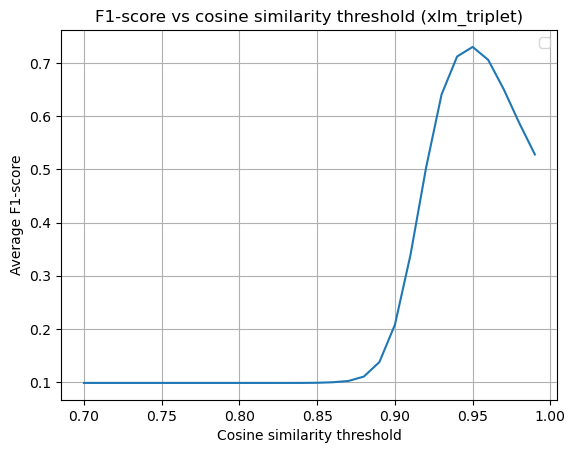

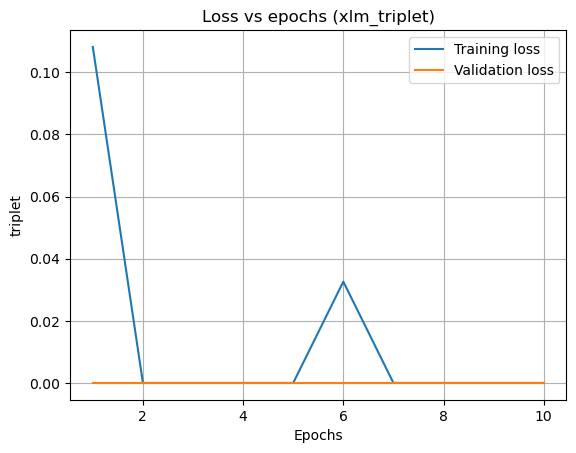

Max f1 score 0.7299346715362949


In [10]:
model_name = 'xlm_triplet_10_epochs'
model_params['mode_train'] = False
model_file = os.path.join('results/', model_name + '.bin')
text_embeddings = get_text_embeddings(valid_df,model_file)
#F1 Scores and visualizer
model_name_val = "xlm_triplet"
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(valid_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_valid') 
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_val,filename = filename)
filename = os.path.join('results/', model_name_val + '_train_and_valid_loss') 
train_loss_df = pd.read_csv(train_loss_file)
valid_loss_df = pd.read_csv(valid_loss_file)
CommonVisualizer().plt_losses( train_loss_df.Train_Loss.values, valid_loss_df.Valid_Loss.values, model_name_val, model_params['loss_module'], filename)
print("Max f1 score",np.max(f1_avg_scores))

### Train F1 Scores

100%|██████████| 857/857 [04:43<00:00,  3.02it/s]


validation loss is  0.0
Our text embeddings shape is (27399, 768)


100%|██████████| 30/30 [05:32<00:00, 11.08s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


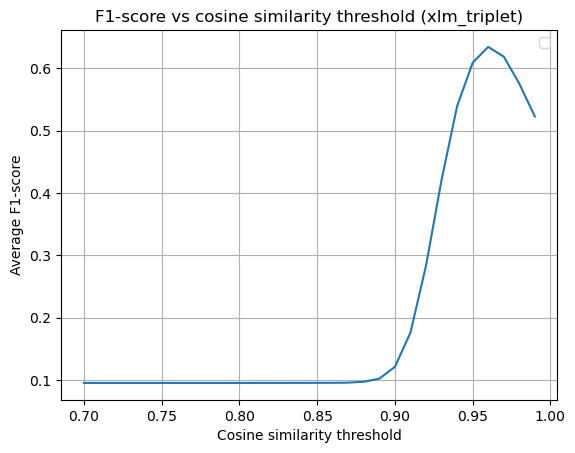

Max f1 score 0.6341665513785981


In [11]:
text_embeddings = get_text_embeddings(train_df,model_file)
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(train_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_train_f1_scores') 
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_val,filename = filename)
print("Max f1 score",np.max(f1_avg_scores))

### Full F1 Scores

100%|██████████| 1071/1071 [05:54<00:00,  3.02it/s]


validation loss is  0.0
Our text embeddings shape is (34250, 768)


100%|██████████| 30/30 [07:01<00:00, 14.06s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


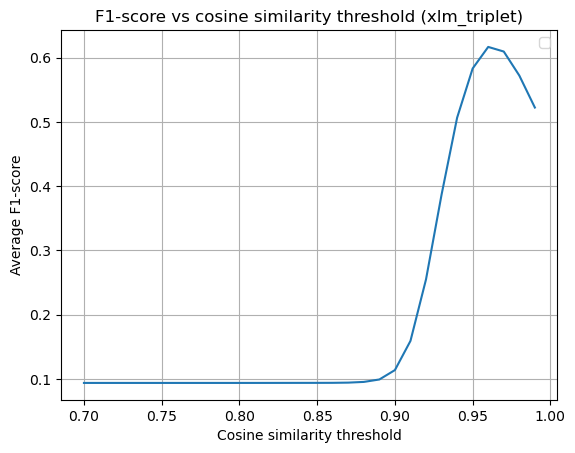

Max f1 score 0.6165134745092078


In [12]:
text_embeddings = get_text_embeddings(full_df,model_file)
text_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=text_embeddings)
f1_avg_scores = F1ScoreEvaluator(full_df,text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
filename = os.path.join('results/', model_name_val + '_full_f1_scores') 
CommonVisualizer().plt_f1_score_vs_threshold(thresholds = thresholds,f1_scores = f1_avg_scores,model_name_and_loss = model_name_val,filename = filename)
print("Max f1 score",np.max(f1_avg_scores))